# Sheet 07

In [15]:
from numpy.typing import NDArray  # trying to be typesafe
import numpy as np  # needed all over the place
import scipy
from scipy.stats import skew
from IPython.display import HTML # in line animations

import os   # file and file path

from itertools import count
import pandas as pd
import matplotlib.pyplot as plt  # for plots

from matplotlib import colors  # not quite sure what fore
from matplotlib.ticker import PercentFormatter  # also not sure, maybe animation..?
from matplotlib.animation import FuncAnimation, FFMpegWriter  # for animations

##### Markov Chain - Monte Carlo  - Metropolis importance Sampling

In [16]:
def initiate_positions_on_grid(
            num_particles: int,
            box: tuple [float, float],

    ) -> np.ndarray:
    """
    Initializes 2D positions on a Grid with even spacing.

    Parameters:
        
        n_particles:(int)
                -> number of particles
        
        box:(tuple[number,number]) 
                -> box size (in [nm])
        
    Return:
        (NDArray[float, shpae=(dimension, number of particles)])
                -> list of vectors of positons that are aranged on a grid
    """
    grid_sections = int(np.ceil(np.sqrt(num_particles)))  # find the number of colums & rows
    # even spacing
    x_spacing = box[0]/grid_sections 
    y_spacing = box[1]/grid_sections
    print("x_spacing:",x_spacing)
    print("y_spacing:",y_spacing)
    # makes grid coordinates
    x, y= np.meshgrid(
        np.arange(grid_sections) * x_spacing, 
        np.arange(grid_sections) * y_spacing
    )        # constants
    x= x.flatten()[:num_particles]+ x_spacing/2
    y= y.flatten()[:num_particles]+ y_spacing/2
    positions= np.linalg.matrix_transpose(np.array([x,y]))
    print("init positions: type",type(positions),"size",np.shape(positions))  
    return positions 

In [17]:
def boundry_conditions(
        rel_vector:np.ndarray,
        box: tuple
) -> np.ndarray:
    """ Determines the position of a vector under boundry conditions.

    Parameters:

    Returns:
    """
    for dim in range(len(box)):
        rel_vector[dim] -= box[dim] * np.round(rel_vector[dim] / box[dim])
    return rel_vector

def relative_distnace(
        x_1: np.ndarray, 
        x_2: np.ndarray, 
        box: tuple
):
    """
    Determines the minimum relative distance over the boundry conditions

    Parameters:
        x_1: (NDArray)
            position Vector of Particle 1
        x_2: (NDArray)
            position Vector of Particle 2
        box: (tuple[float, float])
            simulation box side length [nm] 
    Returns: 
        rel_vector: (NDArray)
            vector; minimal image convention
    """
    rel_vector= x_1 - x_2
    rel_vector= boundry_conditions(rel_vector=rel_vector, box=box)
    return rel_vector 



In [18]:
def initiate_distances(
        positions: np.ndarray,
        box: tuple
) -> np.ndarray:
    """retunrs matrix of distances (vector, scalar).

    Parameters:
        positions: (NDArray)
            -> initial positions; array of vectors

        box: (tuple)
            -> box edge lengths (x_length, y_length)
    
    Return: (tuple)
        vec_distances: (NDArray)
            -> (n x n x dim)-matrix (n= number of particles); relative distance i -> j with periodic boundry conditions and minimum image convention
        
        distances: (NDArray)
            -> (n x n)-matrix; delative distnace, norm value of vec_distances
    """
    vec_distance= np.zeros((len(positions),len(positions),2))
    print("shape of rel_vect=", np.shape(vec_distance))
    for i in range(len(positions)):
        for j in range(i,len(positions)):
            vec_distance[i,j,:]= relative_distnace(positions[i],positions[j], box=box)
            vec_distance[j,i,:]= -vec_distance[i,j,:]
    return vec_distance

In [19]:
def montecarlo_step(shape:tuple, step_size:float) -> np.ndarray:
    """ Determines a random direction to take a step of step_size.
    
    Parameters: 

    Return:    
    """
    dx= np.random.rand(*shape)
    dx= dx / np.linalg.norm(dx,axis=0) * step_size
    return dx

In [20]:
def LJ_potential(r):
    """Lennard-Jones interaction potential; units in kJ.
    """
    return 9.847044e-6/r**12-6.2647225e-3/r**6 

In [ ]:
N=25            
B=(5,5)     # nm
DELTA_X=0.01       # nm
K_B=1.38e-23  # J/K
TEMP= 293.15  # K
ITER=100000

P0 = initiate_positions_on_grid(N,B)
r = initiate_distances(positions=P0,box=B)

collect_distances=np.zeros((ITER,N,N-1))
e=np.zeros((ITER,N))


for iter in range(ITER):
    dx= montecarlo_step(np.shape(P0),DELTA_X)
    for par in range(N):

        d1= np.linalg.norm(np.delete(r[par,:,:],obj=par,axis=0),axis=1)
        e1= np.sum(LJ_potential(d1))

        r2= r[par]+dx[par]
        r2= boundry_conditions(r2,B)
        d2= np.linalg.norm(np.delete(r2,obj=par,axis=0),axis=1)
        e2= np.sum(LJ_potential(d2))

        de= e2-e1
        # E1>=E2 or ln P >= ln q
        if 0>=de or -de/(K_B*TEMP) >= np.log(np.random.uniform(0,1)):
            r[par]=r2
            e[iter, par]= e2
            collect_distances[iter,par]= d2
        else:
            e[iter, par]= e1 
            collect_distances[iter,par]= d1
        


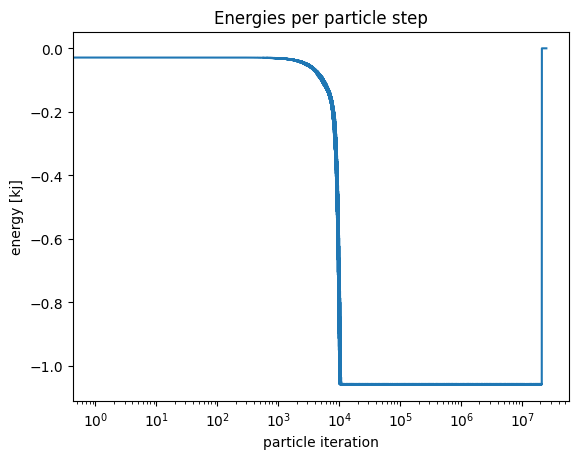

In [ ]:
plt.title("Energies per particle step")
plt.plot(np.arange(ITER*N),e.flatten())
plt.xlabel("particle iteration")
plt.ylabel("energy [kj]")
#plt.xscale("log")
#plt.yscale("log")
plt.savefig("MC-Energies-per-particel-iteration.png")
plt.show()
plt.close()

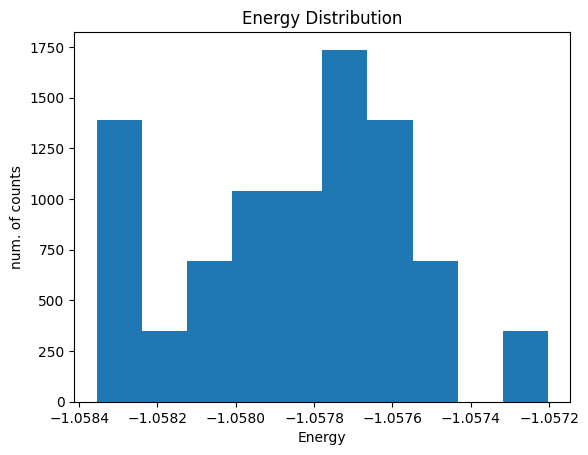

In [ ]:
plt.title("Energy Distribution")
plt.hist(e.flatten()[100000:],density=True)
plt.xlabel("Energy")
plt.ylabel("num. of counts")
plt.savefig("energy-histogram.png")
plt.show()
plt.close()